<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Sloan-Digital-Sky-Survey_SDSS/blob/master/Tutorial_%EC%BD%94%EC%82%AC%EC%9D%B8%EC%8A%A4%EC%BC%80%EC%A5%B4%EB%9F%AC_ADAMWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit #for data splitting
np.random.seed(123) #ensure reproducibility
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

plt.style.use('seaborn') # matplotlib 도 종류가 다양하기 때문에 seaborn 스타일로 지정한 거임.
sns.set(font_scale=1) # (기본으로) 폰트 크기 2.5로 지정 미리 해놓는거임, 2.5면 꽤 크게 나옴

#ignore warnings
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline 


import numpy as np # linear algebra
import pandas as pd 

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from keras.layers import Input, Dense
from keras.models import Model



#train = pd.read_csv('drive/My Drive/데이콘_천체유형/train.csv', index_col=0)
train = pd.read_csv('drive/My Drive/데이콘_천체유형/이상치_최대한_적게_train.csv', index_col=None)
test = pd.read_csv('drive/My Drive/데이콘_천체유형/test.csv', index_col=0)
sample_submission = pd.read_csv('drive/My Drive/데이콘_천체유형/sample_submission.csv', index_col=0)

#######################################################################################################
## petroMag_g 이상치 하나 더 없애기
name = 'petroMag_g'
drop_index = np.argmax(np.array(train[name]))
train = train.drop(index=drop_index,axis=0)
######################################################################################################

print('csv 파일 (train, test, sample)을 불러왔습니다')
print('train shape : {0}'.format(train.shape))
print('test shape : {0}'.format(test.shape))
print('='*50)

train_type_num = train['type_num']
needscaling_train = train.drop(['type','fiberID','type_num'],axis=1)
needscaling_test = test.drop(['fiberID'], axis=1)

sc = StandardScaler()
sc.fit(needscaling_train)
scaled_train = pd.DataFrame(sc.transform(needscaling_train),
                      columns=needscaling_train.columns,
                      index = needscaling_train.index)

scaled_test = pd.DataFrame(sc.transform(needscaling_test),
                      columns=needscaling_test.columns,
                      index = needscaling_test.index)

scaled_train['type_num'] = train_type_num
train_x = scaled_train.drop(['type_num'],axis=1)
train_y = scaled_train['type_num']
test_x = scaled_test

Using TensorFlow backend.


csv 파일 (train, test, sample)을 불러왔습니다
train shape : (199898, 23)
test shape : (10009, 21)


In [0]:
!pip install keras-swa


     |████████████████████████████████| 81kB 4.3MB/s 
  Created wheel for keras-swa: filename=keras_swa-0.1.5-cp36-none-any.whl size=9712 sha256=b9b12f756ae3dbb2ebd57c26aacbce06352c7fa180eb40961f1cac79d6d71f0d
  Stored in directory: /root/.cache/pip/wheels/30/de/a7/f2a71861bb678729a45e8995dc2496118e875e64b89379c530
Successfully built keras-swa


## 딥러닝 모델 파일경로 생성, 지정 (Gelu & ADAMWR)

In [0]:
csv_folder = '0225_이상치1_cosine_ADAMWR_DO=0.4'

import os
SAVEMODEL_NEWFOLDER0 = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder
SAVEMODEL_NEWFOLDER1 = 'drive/My Drive/데이콘_천체유형/기존모델저장/' + csv_folder
#if not os.path.exists(SAVEMODEL_NEWFOLDER1):
#  os.mkdir(SAVEMODEL_NEWFOLDER1)
#  print('모델폴더를 새로 생성했습니다.')
if not os.path.exists(SAVEMODEL_NEWFOLDER0):
  os.mkdir(SAVEMODEL_NEWFOLDER0)
  print('모델폴더를 새로 생성했습니다.')

SUBMISSION_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder
if not os.path.exists(SUBMISSION_NEWFOLDER):
  os.mkdir(SUBMISSION_NEWFOLDER)
  print('제출폴더를 새로 생성했습니다.')

################## StratifiedShuffleSplit 를 이용해서 층화분할 #############
X_array = train_x.values
y_array = train_y.values

sss = StratifiedShuffleSplit(n_splits=2, test_size=1/13, random_state=123)
index1, index2 = sss.split(X_array, y_array)
train_index = index1[0].tolist()
val_index = index1[1].tolist()
train_input = X_array[train_index]
cv_input = X_array[val_index]
train_target  = y_array[train_index]
cv_target = y_array[val_index]

#train_index, val_index = train_test_split(np.arange(len(train_y)),random_state=42, test_size=1/13)
#train_input=train_x.iloc[train_index].values
#train_target0=train_y[train_index]
#train_target=train_target0.values
#cv_input=train_x.iloc[val_index].values
#cv_target0=train_y[val_index]
#cv_target = cv_target0.values



# 코사인스케쥴러



> 스케쥴러도 위의 Reduce LR과 굉장히 유사함. 하지만 스케쥴러는 위와 달리  (Cyclic, Cosine.. 비선형 방법이 가능) 등 여러가지 종류의 스케쥴러로 **patience를 지정해서 쓰는게 아니라** 일정 패턴을 따라 최대값에서 최소값의 사이를 lr이 왔다갔다하며 그 사이에서 학습되도록 함.



> SGD optimizer를 사용해야 하며 clipnorm으로 Gradient Exploding이 없게 하자. <= clip norm으로 제한을 두다보니 수렴속도가 굉장히 느림





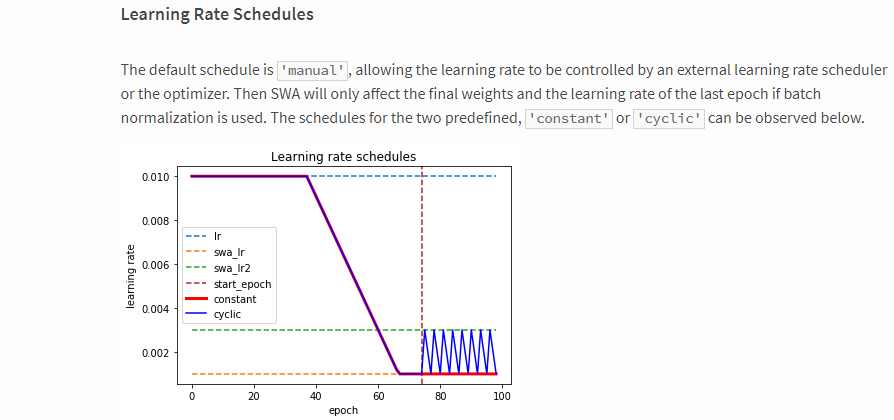

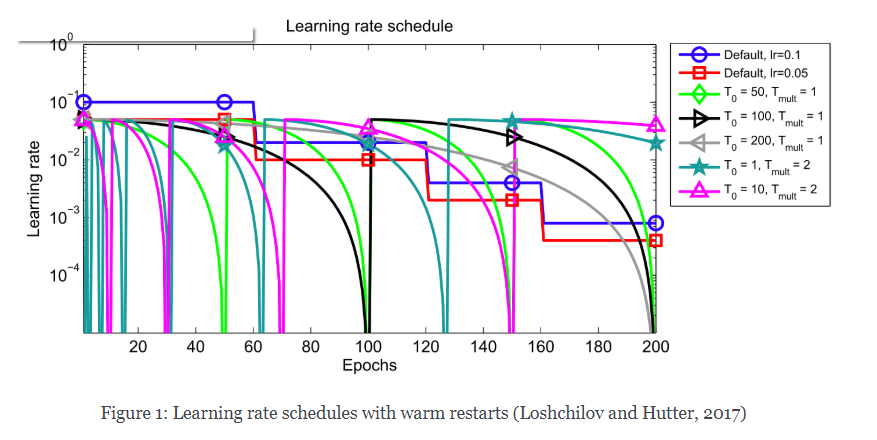

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
from collections import defaultdict

class WRWDScheduler(Callback):
    """Warm restart scheduler for optimizers with decoupled weight decay
    
    This Keras callback should be used with TensorFlow optimizers 
    with decoupled weight decay, such as tf.contrib.opt.AdamWOptimizer
    or tf.contrib.opt.MomentumWOptimizer. Warm restarts include 
    cosine annealing with periodic restarts for both learning rate 
    and weight decay. Normalized weight decay is also included.
    
    # Example
    ```python
    lr = 0.001
    wd = 0.01
    optimizer = tf.contrib.opt.AdamWOptimizer(
        learning_rate=lr,
        weight_decay=wd)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    cb_wrwd = WRWDScheduler(steps_per_epoch=100, lr=lr, wd_norm=wd)
    model.fit(x_train, y_train, callbacks=[cb_wrwd])
    figure(1);plt.plot(cb_wrwd.history['lr'])
    figure(2);plt.plot(cb_wrwd.history['wd'])
    ```
    # Arguments
        steps_per_epoch: number of training batches per epoch
        lr: initial learning rate
        wd_norm: normalized weight decay
        eta_min: minimum of the multiplier
        eta_max: maximum of the multiplier
        eta_decay: decay rate of eta_min/eta_max after each restart
        cycle_length: number of epochs in the first restart cycle
        cycle_mult_factor: rate to increase the number of epochs 
            in a cycle after each restart
    # Reference
        arxiv.org/abs/1608.03983
        arxiv.org/abs/1711.05101
        jeremyjordan.me/nn-learning-rate
    """
    
    def __init__(self,
                 steps_per_epoch,
                 lr=0.001,
                 wd_norm=0.03,
                 eta_min=0.0,
                 eta_max=1.0,
                 eta_decay=1.0,
                 cycle_length=10,
                 cycle_mult_factor=1.5):
        
        self.lr = lr
        self.wd_norm = wd_norm

        self.steps_per_epoch = steps_per_epoch

        self.eta_min = eta_min
        self.eta_max = eta_max
        self.eta_decay = eta_decay

        self.steps_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.cycle_mult_factor = cycle_mult_factor

        self.wd = wd_norm / (steps_per_epoch*cycle_length)**0.5

        self.history = defaultdict(list)

    def cal_eta(self):
        '''Calculate eta'''
        fraction_to_restart = self.steps_since_restart / (self.steps_per_epoch * self.cycle_length)
        eta = self.eta_min + 0.5 * (self.eta_max - self.eta_min) * (1.0 + np.cos(fraction_to_restart * np.pi))
        return eta

    def on_train_batch_begin(self, batch, logs={}):
        '''update learning rate and weight decay'''
        eta = self.cal_eta()
        self.model.optimizer.optimizer._learning_rate = eta * self.lr
        self.model.optimizer.optimizer._weight_decay = eta * self.wd

    def on_train_batch_end(self, batch, logs={}):
        '''Record previous batch statistics'''
        logs = logs or {}
        self.history['lr'].append(self.model.optimizer.optimizer._learning_rate)
        self.history['wd'].append(self.model.optimizer.optimizer._weight_decay)
        for k, v in logs.items():
            self.history[k].append(v)

        self.steps_since_restart += 1

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary'''
        if epoch + 1 == self.next_restart:
            self.steps_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.cycle_mult_factor)
            self.next_restart += self.cycle_length
            self.eta_min *= self.eta_decay
            self.eta_max *= self.eta_decay
            self.wd = self.wd_norm / (self.steps_per_epoch*self.cycle_length)**0.5
        logs = logs or {}
        #logs['lr'] = K.get_value(self.model.optimizer.lr)
        #logs['wd'] = K.get_value(self.model.optimizer.wd)
        
lr=0.001,
wd_norm=0.03,
eta_min=0.0,
eta_max=1.0,
eta_decay=1.0,
cycle_length=10,
cycle_mult_factor=1.5
steps_per_epoch=100

  optimizer = tf.contrib.opt.AdamWOptimizer(
      learning_rate=lr,
      weight_decay=wd)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  cb_wrwd = WRWDScheduler(steps_per_epoch=steps_per_epoch, lr=lr, wd_norm=wd_norm)
  model.fit(x_train, y_train, callbacks=[cb_wrwd])
# steps_per_epoch: number of training batches per epoch
# lr: initial learning rate
# wd_norm: normalized weight decay
# eta_min: minimum of the multiplier
# eta_max: maximum of the multiplier
# eta_decay: decay rate of eta_min/eta_max after each restart
# cycle_length: number of epochs in the first restart cycle
# cycle_mult_factor: rate to increase the number of epochs 
#    in a cycle after each restart



import numpy as np
import pandas as pd

#random seeds for stochastic parts of neural network 
np.random.seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, Model, load_model
from keras.layers import  Activation,  Lambda, Flatten, LeakyReLU, ELU, Dense
from keras.layers import Input, Concatenate, Reshape, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam, SGD, RMSprop
from keras import  backend as K
from keras import metrics
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from swa.keras import SWA # swa optimizer - https://pypi.org/project/keras-swa/
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



################ Gelu #############

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Activation(gelu)})


def create_nn_model():
    inp = Input(shape=(20,))
    x = Dense(2373)(inp)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.4)(x)
    
    x = Dense(2355)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.4)(x)

    x = Dense(1197)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.35)(x)

    x = Dense(1187)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.3)(x)

    x = Dense(612)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.3)(x)

    x = Dense(607)(x)
#    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.3)(x)


    out = Dense(19, activation='softmax')(x) #scalar_coupling_constant    
    model = Model(inputs=inp, outputs=out)
    return model

nn_model = create_nn_model(  )




first_epoch = 100
epoch =  10000

cycle_length = 100
#T_max = 8
mult_factor = 1.5

pat0 = 10
pat = 200
batchsize = 1024
max_lr = 1e-2
min_lr = 1e-5
initial_rate = 0.3   ## Warm up 단계로서 initial_rate를 이용해서 학습해놔준 다음, 코사인스케쥴러 시작
swa_lr = 3e-4
swa_freq = 5
start_epoch = 50 ## SWA를 고려하는 시기 (실질적으로 first_epoch + start_epoch이 swa 시작시기가 되겠다..)
lr_decay = 0.8

############################ Folder 생성 & 경로지정 ############################
import os
MODEL_SAVE_FOLDER_PATH0 = SAVEMODEL_NEWFOLDER0 +  '/initial_rate=%s/' % initial_rate ## checkpoint
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장
#if not os.path.exists(MODEL_SAVE_FOLDER_PATH1):
#  os.mkdir(MODEL_SAVE_FOLDER_PATH1)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH0):
  os.mkdir(MODEL_SAVE_FOLDER_PATH0)

#check_path = MODEL_SAVE_FOLDER_PATH0 + '{epoch:02d}-{val_loss:.4f}.hdf5'
check_path = MODEL_SAVE_FOLDER_PATH0 + f"SGD_Cli_BN_SWA_CoSched_model.hdf5"

json_path = MODEL_SAVE_FOLDER_PATH0 + "model1.json"
#json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH0 +"model1.h5"
#weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"

### model early stopping0 : First Epoch 중 더이상 성능 개선이 되지 않으면 멈춤, val_loss 가장 좋은 모델도 불러옴
es0 = EarlyStopping(monitor= 'val_loss', patience = pat0, verbose = 1, mode='min'
                   , restore_best_weights = True
                   #,min_delta = 1e-6
                   ) 

es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='min'
                   #, restore_best_weights = True
                   #,min_delta = 1e-6
                   ) 
### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='min', save_best_only=True)

## Scheduler
sgdr = SGDRScheduler(min_lr=min_lr,
                      max_lr=max_lr,
                      steps_per_epoch=np.ceil(epoch/batchsize),
                      lr_decay=lr_decay,
                      cycle_length=cycle_length,
                      mult_factor=mult_factor)

### Stochastic Weight Averaging - schedule 을 manual로 설정했기 때문에 위에 설정한 코사인 스케쥴러를 사용할 수 있는 거임.
swa = SWA(start_epoch=start_epoch, lr_schedule='manual', swa_lr=swa_lr, swa_freq=swa_freq, verbose=1,batch_size=batchsize)


from keras import optimizers
optimizer = optimizers.SGD(
    lr=initial_rate   , clipnorm=1.
)

## compile model
CCE = metrics.sparse_categorical_crossentropy

nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              #metrics=['accuracy']
              #metrics=[metrics.sparse_categorical_accuracy]
              metrics=[CCE]
              )


## fitting model0 ( Base model )
hist = nn_model.fit(  train_input, train_target,validation_data=[cv_input, cv_target],
                    batch_size=batchsize,
                    epochs=first_epoch,
                    callbacks = [es0    ## First Epoch 중에서 best_val_loss에 해당하는 친구를 nn_mmodel의 결과로 불러와버리자
                                 ,mc
                                 #,sgdr
                                 #,swa
                                 #,rlr
                                ] )

print('Warm-up start model fitting을 마쳤습니다')
loss_and_metric = nn_model.evaluate(train_input, train_target, batch_size=batchsize, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))
loss_and_metric = nn_model.evaluate(cv_input, cv_target, batch_size=batchsize, verbose=0)
print("valid, loss and metric: {}".format(loss_and_metric))
print('='*100)
## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save ## 기존 모델의 가중치 저장
nn_model.save_weights(weight_path)
print('Warm-up start model을 저장했습니다.')
print('='*100)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 184521 samples, validate on 15377 samples
Epoch 1/100





184521/184521 [==============================] - 18s 97us/step - loss: 0.8497 - sparse_categorical_crossentropy: 0.8497 - val_loss: 0.6051 - val_sparse_categorical_crossentropy: 0.6051
Epoch 2/100
184521/184521 [==============================] - 7s 39us/step - loss: 0.5804 - sparse_categorical_crossentropy: 0.5804 - val_loss: 0.5551 - val_sparse_categorical_crossentropy: 0.5551
Epoch 3/100
184521/184521 [==============================] - 7s 39us/step - loss: 0.5375 - sparse_categorical_crossentropy: 0.5375 - val_loss: 0.5248 - val_sparse_categorical_crossentropy: 0.5248
Epoch 4/100
184521/184521 [==============================] - 7s 39us/step - loss: 0.5130 - sparse_categorical_crossentropy: 0.5130 - val_

train, loss and metric: [0.3786968841885759, 0.3786968841885759]
train, loss and metric: [0.3937973553239582, 0.3937973553239582]


## 밑에 이게 진짜임

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np



### Github에서 새로 가져온 SGDRScheduler

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)



import numpy as np
import pandas as pd

#random seeds for stochastic parts of neural network 
np.random.seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, Model, load_model
from keras.layers import  Activation,  Lambda, Flatten, LeakyReLU, ELU, Dense
from keras.layers import Input, Concatenate, Reshape, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam, SGD,RMSprop
from keras import  backend as K
from keras import metrics
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from swa.keras import SWA # swa optimizer - https://pypi.org/project/keras-swa/
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



################ Gelu #############

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Activation(gelu)})


def create_nn_model():
    inp = Input(shape=(20,))
    x = Dense(2373)(inp)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.4)(x)
    
    x = Dense(2355)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.4)(x)

    x = Dense(1197)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.35)(x)

    x = Dense(1187)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.3)(x)

    x = Dense(612)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.3)(x)

    x = Dense(607)(x)
#    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.3)(x)


    out = Dense(19, activation='softmax')(x) #scalar_coupling_constant    
    model = Model(inputs=inp, outputs=out)
    return model

nn_model = create_nn_model(  )




first_epoch = 100
initial_rate = 0.3   ## Warm up 단계로서 initial_rate를 이용해서 학습해놔준 다음, 코사인스케쥴러 시작
pat0 = 10

epoch =  1000

cycle_length = 50
#T_max = 8
mult_factor = 1.4

pat = 200
batchsize = 1024
max_lr = 1e-1
min_lr = 1e-3
swa_lr = 3e-3
swa_freq = 5
start_epoch = 40 ## SWA를 고려하는 시기 (실질적으로 first_epoch + start_epoch이 swa 시작시기가 되겠다..)
lr_decay = 0.75

############################ Folder 생성 & 경로지정 ############################
import os
MODEL_SAVE_FOLDER_PATH0 = SAVEMODEL_NEWFOLDER0 +  '/initial_rate=%s/' % initial_rate ## checkpoint
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장
#if not os.path.exists(MODEL_SAVE_FOLDER_PATH1):
#  os.mkdir(MODEL_SAVE_FOLDER_PATH1)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH0):
  os.mkdir(MODEL_SAVE_FOLDER_PATH0)

#check_path = MODEL_SAVE_FOLDER_PATH0 + '{epoch:02d}-{val_loss:.4f}.hdf5'
check_path = MODEL_SAVE_FOLDER_PATH0 + f"SGD_Cli_BN_SWA_CoSched_model.hdf5"

json_path = MODEL_SAVE_FOLDER_PATH0 + "model1.json"
#json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH0 +"model1.h5"
#weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"

### model early stopping0 : First Epoch 중 더이상 성능 개선이 되지 않으면 멈춤, val_loss 가장 좋은 모델도 불러옴
es0 = EarlyStopping(monitor= 'val_loss', patience = pat0, verbose = 1, mode='min'
                   , restore_best_weights = True
                   #,min_delta = 1e-6
                   ) 

es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='min'
                   #, restore_best_weights = True
                   #,min_delta = 1e-6
                   ) 
### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='min', save_best_only=True)

## Scheduler
sgdr = SGDRScheduler(min_lr=min_lr,
                      max_lr=max_lr,
                      steps_per_epoch=np.ceil(epoch/batchsize),
                      lr_decay=lr_decay,
                      cycle_length=cycle_length,
                      mult_factor=mult_factor)

### Stochastic Weight Averaging - schedule 을 manual로 설정했기 때문에 위에 설정한 코사인 스케쥴러를 사용할 수 있는 거임.
swa = SWA(start_epoch=start_epoch, lr_schedule='manual', swa_lr=swa_lr, swa_freq=swa_freq, verbose=1,batch_size=batchsize)


from keras import optimizers
optimizer = optimizers.SGD(
    lr=initial_rate   , clipnorm=1.
)

## compile model
CCE = metrics.sparse_categorical_crossentropy

nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              #metrics=['accuracy']
              #metrics=[metrics.sparse_categorical_accuracy]
              metrics=[CCE]
              )


## fitting model0 ( Base model )
hist = nn_model.fit(  train_input, train_target,validation_data=[cv_input, cv_target],
                    batch_size=batchsize,
                    epochs=first_epoch,
                    callbacks = [es0    ## First Epoch 중에서 best_val_loss에 해당하는 친구를 nn_mmodel의 결과로 불러와버리자
                                 ,mc
                                 #,sgdr
                                 #,swa
                                 #,rlr
                                ] )

print('Warm-up start model fitting을 마쳤습니다')
loss_and_metric = nn_model.evaluate(train_input, train_target, batch_size=batchsize, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))
loss_and_metric = nn_model.evaluate(cv_input, cv_target, batch_size=batchsize, verbose=0)
print("valid, loss and metric: {}".format(loss_and_metric))
print('='*100)
## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save ## 기존 모델의 가중치 저장
nn_model.save_weights(weight_path)
print('Warm-up start model을 저장했습니다.')
print('='*100)

## The real fitting model
print("SGDWR(with Cos schedule) 모델 피팅을 시작합니다")
hist = nn_model.fit(  train_input, train_target,validation_data=[cv_input, cv_target],
                    batch_size=batchsize,
                    epochs=epoch,
                    callbacks = [es 
                                 ,mc
                                 ,sgdr
                                 ,swa
                                 #,rlr
                                ] )

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

#acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
#acc_ax.set_ylabel('accuracy')
#acc_ax.legend(loc='upper left')
plt.show()

## evaluate model
print('기존nn모델의 train loss를 출력합니다')
loss_and_metric = nn_model.evaluate(train_input, train_target, batch_size=batchsize, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))
## evaluate model
print('기존nn모델의 valid loss를 출력합니다')
loss_and_metric = nn_model.evaluate(cv_input, cv_target, batch_size=batchsize, verbose=0)
print("valid, loss and metric: {}".format(loss_and_metric))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 184521 samples, validate on 15377 samples
Epoch 1/100





184521/184521 [==============================] - 20s 111us/step - loss: 0.8497 - sparse_categorical_crossentropy: 0.8497 - val_loss: 0.6051 - val_sparse_categorical_crossentropy: 0.6051
Epoch 2/100
184521/184521 [==============================] - 10s 54us/step - loss: 0.5804 - sparse_categorical_crossentropy: 0.5804 - val_loss: 0.5552 - val_sparse_categorical_crossentropy: 0.5552
Epoch 3/100
184521/184521 [==============================] - 10s 54us/step - loss: 0.5375 - sparse_categorical_crossentropy: 0.5375 - val_loss: 0.5249 - val_sparse_categorical_crossentropy: 0.5249
Epoch 4/100
184521/184521 [==============================] - 10s 54us/step - loss: 0.5130 - sparse_categorical_crossentropy: 0.5130 - 

In [0]:

cl = 50
r = 1.4
total = 0
for i in range(1,7):
  mul = r**i
  total = total + cl * mul  
print(total)


original = 1e-1
d = 0.75

print(original * (d**6))

1142.6687999999997
0.0177978515625


In [0]:
index_epoch = [i for i in range(len(hist.history['lr']))]

learning_rate = hist.history['lr']
init_rate = [initial_rate for i in range(len(hist.history['lr']))]
max_learn = [max_lr for i in range(len(hist.history['lr']))]
min_learn = [min_lr for i in range(len(hist.history['lr']))]
swa_learn = [swa_lr for i in range(len(hist.history['lr']))]


plt.figure(figsize=(12, 3))
plt.plot(index_epoch, learning_rate, linestyle='-', linewidth=1, color='y')
plt.plot(index_epoch, init_rate, linestyle='--', linewidth=3, color='g') 
plt.plot(index_epoch, swa_learn, linestyle='--', linewidth=3, color='m')
plt.plot(index_epoch, max_learn, linestyle='--', linewidth=3, color='b') 
plt.plot(index_epoch, min_learn, linestyle='--', linewidth=3, color='k')

plt.axvline(x=start_epoch, color='r', linestyle='--', linewidth=3)

plt.xlim()
plt.ylim()
plt.title('Learning rate Change on N_epoch', fontsize=20) 
plt.ylabel('learning rate', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['learning_rate', 'init_rate', 'swa_learn', 'max_learn', 'min_learn'], fontsize=12, loc='best')
plt.show()



0.0013421772800000006

In [0]:
savingpath_csv = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder + f'/Clip_Cosine_SGDWR_min={min_lr}_max={max_lr}.csv'

print('best_n_epoch는 다음과 같습니다')
print(np.argmin(hist.history['val_loss']))
print('='*50)
print('가장 적절한 rate는 다음과 같습니다')
print(hist.history['lr'][np.argmin(hist.history['val_loss'])])
print('='*25)
y_pred = nn_model.predict(test_x)
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv(savingpath_csv, index=True)
print('csv 저장완료')

print('='*50)
best_val_loss = np.min(hist.history['val_loss'])
print("best_valid_loss: {}".format(best_val_loss))


## 위에꺼가 최신, 아래는 했던거 (비교를 위해서 남겨둠) 곧 삭제 ㄱ
## initial_rate = 1e-3 (SGD 이용함)

### 1. initial rate를 이용해서 start_epoch 전까지 Warm-up 해줌
### 2. start_epoch 부터 eta_max ~ eta_min 까지 왔다갔다 하면서 에포크 돌아감
### 3. eta_max ~ eta_min 왔다갔다하면서 많은 local minima를 찾음
### 4. local minima들을 다 모아서 앙상블해버림

### 1. local minima 문제 없애려면 lr을 줄여라
### 2. 과적합을 막고싶다면 Drop Out 비율 더 높게, layer와 Dense 더 얕게(여기선 일단 안함)
### 3. Gradient Exploding 문제 해결을 하고 싶다면... clip value 지정해줘야 할 듯

Train on 184521 samples, validate on 15377 samples
Epoch 1/800
184521/184521 [==============================] - 11s 59us/step - loss: 0.9203 - sparse_categorical_crossentropy: 0.9203 - val_loss: 0.6011 - val_sparse_categorical_crossentropy: 0.6011
Epoch 2/800
184521/184521 [==============================] - 8s 42us/step - loss: 0.5827 - sparse_categorical_crossentropy: 0.5827 - val_loss: 0.5240 - val_sparse_categorical_crossentropy: 0.5240
Epoch 3/800
184521/184521 [==============================] - 8s 43us/step - loss: 0.5380 - sparse_categorical_crossentropy: 0.5380 - val_loss: 0.4968 - val_sparse_categorical_crossentropy: 0.4968
Epoch 4/800
184521/184521 [==============================] - 8s 44us/step - loss: 0.5137 - sparse_categorical_crossentropy: 0.5137 - val_loss: 0.4764 - val_sparse_categorical_crossentropy: 0.4764
Epoch 5/800
184521/184521 [==============================] - 8s 43us/step - loss: 0.4974 - sparse_categorical_crossentropy: 0.4974 - val_loss: 0.4892 - val_sparse_c

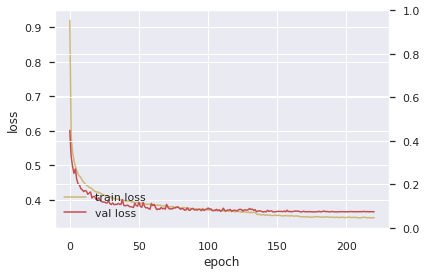

기존nn모델의 train loss를 출력합니다
train, loss and metric: [0.3267460208018521, 0.3267460208018521]
기존nn모델의 valid loss를 출력합니다
valid, loss and metric: [0.36425981141465485, 0.36425981141465485]


In [0]:
epoch =  2000
T_max = 100
pat = T_max*2
batchsize = 256*4
initial_rate = 1e-3   ## Warm up 단계로서 initial_rate를 이용해서 학습해놔준 다음, start_epoch 부터 코사인스케쥴러 시작
eta_max = 3e-4        ## 이건 진짜 범위의 최댓값이다.. initial rate 와 swa_lr이 얘보다 커버리면, eta_max가 lr과 swa_lr이 되어버린다
eta_min = 1e-6        ## 얘는 언제나 lr의 최솟값
swa_lr = initial_rate   ## 지정해줬던 start_epoch부터는 얘가 lr의 최댓값이 됨
swa_freq = 5
start_epoch = 30

#initial_rate = 1e-3 
#factor = 1/np.sqrt(10) # red_patience 만큼 기다리다가, 학습률을 *factor 배로 줄여버림 
#minimumlr = 1e-7       # Reduce learning on Plateau
#red_pat =  25

############################ Folder 생성 & 경로지정 ############################
import os
MODEL_SAVE_FOLDER_PATH0 = SAVEMODEL_NEWFOLDER0 +  '/initial_rate=%s/' % initial_rate ## checkpoint
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장
#if not os.path.exists(MODEL_SAVE_FOLDER_PATH1):
#  os.mkdir(MODEL_SAVE_FOLDER_PATH1)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH0):
  os.mkdir(MODEL_SAVE_FOLDER_PATH0)

#check_path = MODEL_SAVE_FOLDER_PATH0 + '{epoch:02d}-{val_loss:.4f}.hdf5'
check_path = MODEL_SAVE_FOLDER_PATH0 + f"SGD_Cli_BN_SWA_CoSched_model.hdf5"

json_path = MODEL_SAVE_FOLDER_PATH0 + "model1.json"
#json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH0 +"model1.h5"
#weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"




### model early stopping : 더이상 성능 개선이 되지 않으면 멈춤
es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='min'
                    #,restore_best_weights = True
                   ) 

### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='min', save_best_only=True)

## ReduceLR on Plateau : val_loss가 안 줄어들 때 lr을 작게 할 수 있음 (local minima 대처방법)
rlr = ReduceLROnPlateau(monitor='val_loss', factor = factor,   # patience 만큼 기다리다가 0.1이면 학습률을 0.1배로 줄여버림 
                        patience = red_pat, mode = 'min', verbose = 1,
                        min_lr = minimumlr
                        )

## Cosine Scheduler
cosine_scheduler = CosineAnnealingScheduler(T_max=T_max, eta_max=eta_max, eta_min=eta_min)

### Stochastic Weight Averaging - schedule 을 manual로 설정했기 때문에 위에 설정한 코사인 스케쥴러를 사용할 수 있는 거임.
swa = SWA(start_epoch=start_epoch, lr_schedule='manual', swa_lr=swa_lr, swa_freq=swa_freq, verbose=1,batch_size=batchsize)



####################################### Optimizer SGD로 바꿔줬음 ###############################
from keras import optimizers
optimizer = optimizers.SGD(
    lr=initial_rate,
    clipnorm=1.
)

## compile model
CCE = metrics.sparse_categorical_crossentropy

nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              #metrics=['accuracy']
              #metrics=[metrics.sparse_categorical_accuracy]
              metrics=[CCE]
              )

## fitting model
hist = nn_model.fit(  train_input, train_target,validation_data=[cv_input, cv_target],
                    batch_size=batchsize,
                    epochs=epoch,
                    callbacks = [es 
                                 ,cosine_scheduler
                                 ,swa
                                 ,mc
                                 #,rlr
                                ] )

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

#acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
#acc_ax.set_ylabel('accuracy')
#acc_ax.legend(loc='upper left')
plt.show()

## evaluate model
print('기존nn모델의 train loss를 출력합니다')
loss_and_metric = nn_model.evaluate(train_input, train_target, batch_size=batchsize, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))
## evaluate model
print('기존nn모델의 valid loss를 출력합니다')
loss_and_metric = nn_model.evaluate(cv_input, cv_target, batch_size=batchsize, verbose=0)
print("valid, loss and metric: {}".format(loss_and_metric))
## model weight save ## 기존 모델의 가중치 저장
#nn_model.save_weights(weight_path)

In [0]:
savingpath_csv = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder + '/clip_cosine_SGD__initial_rate_%s.csv' % initial_rate

print('best_n_epoch는 다음과 같습니다')
print(np.argmin(hist.history['val_loss']))
print('='*50)
print('final rate는 다음과 같습니다')
print(hist.history['lr'][np.argmin(hist.history['val_loss'])])
print('='*25)
y_pred = nn_model.predict(test_x)
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv(savingpath_csv, index=True)
print('csv 저장완료')

print('='*50)
best_val_loss = np.min(hist.history['val_loss'])
print("best_valid_loss: {}".format(best_val_loss))


final rate는 다음과 같습니다
3.1622774e-05
csv 저장완료
best_valid_loss: 0.36425981141465485


# 저장된 모델 로드해오기

In [0]:
initial_rate = 1e-2
SAVEMODEL_NEWFOLDER1 = 'drive/My Drive/데이콘_천체유형/기존모델저장/' + csv_folder
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장

## model load
json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"

from keras.models import model_from_json
json_file = open(json_path, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
## model weight load
loaded_model.load_weights(weight_path)

## model load and evaluation
from keras import optimizers
final_rate = hist.history['lr'][np.argmin(hist.history['val_loss'])]
print("Loaded model from disk")
load_optimizer = optimizers.Adam(
    lr=final_rate,
)
CCE = metrics.sparse_categorical_crossentropy
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=load_optimizer
                     ,metrics=[CCE]
                     )
batchsize=1024
train_score = loaded_model.evaluate(train_input,train_target,verbose=0, batch_size=batchsize)
print('Load한 Check모델의 train loss를 출력합니다')
print("train, loss and metric: {}".format(train_score))
cv_score = loaded_model.evaluate(cv_input,cv_target,verbose=0, batch_size=batchsize)
print('Load한 Check모델의 val loss를 출력합니다')
print("valid, loss and metric: {}".format(cv_score))

Loaded model from disk
Load한 Check모델의 train loss를 출력합니다
train, loss and metric: [0.3077159990481829, 0.3077159990481829]
Load한 Check모델의 val loss를 출력합니다
valid, loss and metric: [0.3495782041837298, 0.3495782041837298]


In [0]:
csv_folder = ''
SAVEMODEL_NEWFOLDER1 = 'drive/My Drive/데이콘_천체유형/기존모델저장/' + csv_folder
initial_rate = 0.01
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장

## model load
json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"

from keras.models import model_from_json
json_file = open(json_path, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
## model weight load
loaded_model.load_weights(weight_path)

## model load and evaluation
from keras import optimizers
#final_rate = hist.history['lr'][np.argmin(hist.history['val_loss'])]
print("Loaded model from disk")
load_optimizer = optimizers.Adam(
    #lr=final_rate
    lr = 0.0003162278
)
CCE = metrics.sparse_categorical_crossentropy
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=load_optimizer
                     ,metrics=[CCE]
                     )

Loaded model from disk


